In [2]:
from prophet import Prophet
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from govuk_bank_holidays.bank_holidays import BankHolidays


c:\Users\izzfa\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Data

In [3]:
filepath_barn = "../../Data/ward_data.parquet"

barnet = pq.read_pandas(filepath_barn).to_pandas()
# Remove commas and convert to integers
barnet['Mid-2020 population'] = barnet['Mid-2020 population'].str.replace(',', '').astype(int)
barnet['People per Sq Km'] = barnet['People per Sq Km'].str.replace(',', '').astype(int)

burglary_counts = barnet.groupby(['Month', 'WD22NM'])['Crime type'].count().reset_index()
burglary_counts.rename(columns={'Crime type': 'Burglaries'}, inplace=True)
barnet = barnet.merge(burglary_counts, on=['Month','WD22NM'], how='left')

barnet['Month'] = pd.to_datetime(barnet['Month'])
barnet = barnet.sort_values('Month')
barnet

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA21NM,WD22NM,LSOA Code,Mid-2020 population,Area Sq Km,People per Sq Km,Burglaries
25504,None,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.164205,51.613222,On or near Lewes Road,E01000324,Barnet 015F,Burglary,None,NaN,Barnet 015F,Woodhouse,E01000324,1851,0.27,6820,10
31048,None,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.157661,51.652137,On or near Langford Road,E01000166,Barnet 003A,Burglary,None,NaN,Barnet 003A,East Barnet,E01000166,1619,0.37,4379,16
8551,None,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.186585,51.604371,On or near Willow Way,E01000298,Barnet 023D,Burglary,None,NaN,Barnet 023D,West Finchley,E01000298,2007,0.27,7545,27
19476,None,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.213734,51.567559,On or near Cotswold Gardens,E01000222,Barnet 040C,Burglary,None,NaN,Barnet 040C,Cricklewood,E01000222,1975,0.42,4748,11
19477,None,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.214454,51.570906,On or near Prayle Grove,E01000222,Barnet 040C,Burglary,None,NaN,Barnet 040C,Cricklewood,E01000222,1975,0.42,4748,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30048,5edebc29e8ee6a316ce91e3dc7de4cacafe6901d6a1045...,2023-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.188374,51.574652,On or near Corringham Road,E01000214,Barnet 038E,Burglary,Under investigation,NaN,Barnet 038E,Childs Hill,E01000214,1909,0.33,5762,20
18013,b6106017b050bf4b1f4d17100c391c6fcd626985049973...,2023-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.215314,51.557290,On or near,E01000141,Barnet 039A,Burglary,Under investigation,NaN,Barnet 039A,Cricklewood,E01000141,2258,0.37,6094,9
18014,2ab650a481ac9e02643ee99659a846237f2d25006aab8e...,2023-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.216684,51.559259,On or near Kara Way,E01000141,Barnet 039A,Burglary,Under investigation,NaN,Barnet 039A,Cricklewood,E01000141,2258,0.37,6094,9
38649,e52bf021cbf673d1a3742f2ffc7033f164958ebdf5ad25...,2023-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.205638,51.652907,On or near Coe'S Alley,E01000250,Barnet 001C,Burglary,Under investigation,NaN,Barnet 001C,High Barnet,E01000250,2793,0.58,4803,6


# Processing Data

In [118]:
allW = barnet[['Month', 'WD22NM', 'Burglaries']]
allW = allW.drop_duplicates()

# Group the data by ward and aggregate the number of burglaries
allW = allW.groupby(['Month', 'WD22NM']).sum().reset_index()

# Create a new dataframe with the dates and aggregated number of burglaries per ward
ward_data = allW.pivot(index='Month', columns='WD22NM', values='Burglaries')
ward_data = ward_data.reset_index()


# Rename columns to match Prophet's requirements
ward_data.rename(columns={'Month': 'ds'}, inplace=True)
wd2 = ward_data.copy()
# Create a column for the total number of burglaries across all wards
wd2['Total'] = wd2.drop('ds', axis=1).sum(axis=1)
wd2['Mean'] = wd2.drop('ds', axis=1).mean(axis=1)
wd2['Std'] = wd2.drop('ds', axis=1).std(axis=1)
# Set 'Date' column as the index
ward_data.set_index('ds', inplace=True)

# Linear interpolation to impute missing values or extend existing data
df_interpolated = ward_data.interpolate(method='linear')

# Reset index to restore the 'Date' column
df_interpolated.reset_index(inplace=True)

# Print the imputed dataframe
# df_interpolated
total = wd2[['ds','Total']].rename(columns={'Total': 'y'})
mean = wd2[['ds','Mean']].rename(columns={'Mean': 'y'})
std = wd2[['ds','Std']].rename(columns={'Std': 'y'})
wd2

WD22NM,ds,Barnet Vale,Brunswick Park,Burnt Oak,Childs Hill,Colindale North,Cricklewood,East Barnet,East Finchley,Edgware,...,Mill Hill,Totteridge & Woodside,Underhill,West Finchley,West Hendon,Whetstone,Woodhouse,Total,Mean,Std
0,2010-12-01,13.0,13.0,10.0,20.0,7.0,11.0,16.0,18.0,20.0,...,25.0,10.0,8.0,27.0,16.0,9.0,10.0,363.0,30.250000,69.673793
1,2011-01-01,23.0,15.0,14.0,41.0,5.0,13.0,20.0,19.0,12.0,...,30.0,17.0,15.0,30.0,19.0,14.0,21.0,476.0,39.666667,91.288310
2,2011-02-01,20.0,22.0,10.0,24.0,5.0,20.0,12.0,13.0,13.0,...,18.0,13.0,5.0,23.0,22.0,15.0,17.0,395.0,32.916667,75.737990
3,2011-03-01,15.0,13.0,6.0,33.0,8.0,25.0,13.0,14.0,4.0,...,23.0,8.0,22.0,22.0,12.0,17.0,6.0,399.0,33.250000,76.768727
4,2011-04-01,25.0,15.0,16.0,37.0,6.0,28.0,15.0,8.0,9.0,...,15.0,16.0,18.0,23.0,15.0,17.0,11.0,403.0,33.583333,77.392354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2022-11-01,5.0,4.0,11.0,32.0,5.0,15.0,5.0,3.0,8.0,...,7.0,13.0,5.0,16.0,11.0,11.0,15.0,234.0,19.500000,45.137752
144,2022-12-01,9.0,5.0,13.0,21.0,6.0,13.0,11.0,6.0,10.0,...,13.0,15.0,3.0,9.0,9.0,10.0,7.0,211.0,18.347826,41.287548
145,2023-01-01,5.0,7.0,11.0,21.0,5.0,13.0,9.0,5.0,10.0,...,10.0,15.0,5.0,17.0,11.0,NaN,4.0,223.0,19.391304,43.648536
146,2023-02-01,2.0,14.0,4.0,21.0,3.0,15.0,5.0,5.0,11.0,...,12.0,12.0,2.0,5.0,10.0,3.0,6.0,184.0,15.333333,35.525421


# Model for all of barnet burglaries

In [123]:
# Define the start and end dates
start_date = '2010-12-01'
end_date = '2024-03-01'

# Generate the date range with frequency set to 'MS' (Month Start)
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

In [114]:
m1 = Prophet(interval_width=0.95, seasonality_mode='additive',yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.2)
m2 = Prophet(interval_width=0.95, seasonality_mode='additive',yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.05)
m3 = Prophet(interval_width=0.95, seasonality_mode='additive',yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.1)

model1 = m1.fit(total)
model2 = m2.fit(mean)
model3 = m3.fit(std)

14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
# Make predictions for each ward
future1 = m1.make_future_dataframe(periods=12, freq='M')
future2 = m2.make_future_dataframe(periods=12, freq='M')
future3 = m3.make_future_dataframe(periods=12, freq='M')
forecast1 = m1.predict(future1)
forecast2 = m2.predict(future2)
forecast3 = m3.predict(future3)
forecast1.set_index('ds', inplace=True)
forecast2.set_index('ds', inplace=True)
forecast3.set_index('ds', inplace=True)

regressors = pd.DataFrame()
regressors['Total'] = forecast1[['yhat']]
regressors['Mean'] = forecast2[['yhat']]
regressors['Std'] = forecast3[['yhat']]
regressors = regressors.reset_index()
regressors['ds'] = date_range
regressors

,ds,Total,Mean,Std
0,2010-12-01,436.408195,35.217555,83.266714
1,2011-01-01,446.500136,36.012577,85.105225
2,2011-02-01,413.270692,33.271713,78.807473
3,2011-03-01,409.604412,32.571956,78.181302
4,2011-04-01,387.456078,31.158444,73.560399
...,...,...,...,...
155,2023-11-01,196.229095,17.125433,37.776019
156,2023-12-01,220.691371,20.331877,42.297910
157,2024-01-01,200.105504,18.458264,38.411737
158,2024-02-01,145.988180,14.418726,28.904290


# Model for per ward

In [99]:
# Initialize a dictionary to store the forecasts per ward
ward_forecasts = {}
# Iterate over each ward
for ward in df_interpolated.columns[1:]:
    # Create a new dataframe for the current ward
    ward_df = df_interpolated[['ds', ward]].rename(columns={ward: 'y'})
    m4 = Prophet(interval_width=0.95, seasonality_mode='additive',yearly_seasonality=True, 
                 weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.2, seasonality_prior_scale=7.0,)
    
    m4.fit(ward_df)
    # Make future predictions for the current ward
    future = m4.make_future_dataframe(periods=12, freq='M')
    

    forecast = m4.predict(future)

    # forecast.set_index('ds', inplace=True)

    # Store the forecast for the current ward in the dictionary
    # ward_forecasts[ward] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    ward_forecasts[ward] = forecast



14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:22 - cmdstanpy - INFO - Chain [1] done processing
14:28:22 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:23 - cmdstanpy - INFO - Chain [1] done processing
14:28:23 - cmdstanpy - INFO - Chain [1] start processing
14:28:24 - cmdstanpy - INFO - Chain [1] done processing
14:28:24 - cmdstanpy - INFO - Chain [1] start processing
14:28:24 - cmdstanpy - INFO - Chain [1]

In [100]:
# Access the forecast for a specific ward
specific_ward_forecast = ward_forecasts['Barnet Vale']
# Print the forecast for a specific ward
specific_ward_forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,19.587925,14.182426,33.219248,19.587925,19.587925,4.261620,4.261620,4.261620,4.261620,4.261620,4.261620,0.0,0.0,0.0,23.849545
1,2011-01-01,19.496808,11.405733,30.049519,19.496808,19.496808,1.488042,1.488042,1.488042,1.488042,1.488042,1.488042,0.0,0.0,0.0,20.984850
2,2011-02-01,19.405690,9.847246,28.756528,19.405690,19.405690,-0.162080,-0.162080,-0.162080,-0.162080,-0.162080,-0.162080,0.0,0.0,0.0,19.243610
3,2011-03-01,19.323390,9.516180,28.059442,19.323390,19.323390,-0.462317,-0.462317,-0.462317,-0.462317,-0.462317,-0.462317,0.0,0.0,0.0,18.861074
4,2011-04-01,19.232273,8.133299,26.615110,19.232273,19.232273,-2.307112,-2.307112,-2.307112,-2.307112,-2.307112,-2.307112,0.0,0.0,0.0,16.925161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2023-10-31,3.844583,1.295827,19.038352,3.820910,3.866517,6.153903,6.153903,6.153903,6.153903,6.153903,6.153903,0.0,0.0,0.0,9.998485
156,2023-11-30,3.719993,-5.160217,13.915877,3.692059,3.746798,0.557585,0.557585,0.557585,0.557585,0.557585,0.557585,0.0,0.0,0.0,4.277578
157,2023-12-31,3.591250,-5.064846,13.515561,3.557432,3.622200,1.090427,1.090427,1.090427,1.090427,1.090427,1.090427,0.0,0.0,0.0,4.681677
158,2024-01-31,3.462508,-7.360389,11.651290,3.422221,3.498228,-1.216769,-1.216769,-1.216769,-1.216769,-1.216769,-1.216769,0.0,0.0,0.0,2.245739


In [101]:
# Define the start and end dates
start_date = '2010-12-01'
end_date = '2024-03-01'

# Generate the date range with frequency set to 'MS' (Month Start)
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')


In [127]:
import math
forecastedW = {}

for ward in ward_forecasts:
    
    # Get the last two forecasted values for the ward
    # values = ward_forecasts[ward]['yhat'].iloc[-2:].values.tolist()
    values = ward_forecasts[ward]['yhat'].values.tolist()
    # Get the absolute values of the 'values' list
    abs_values = [math.ceil(abs(value)) for value in values]
        
    # Append the ward and its values to the dictionary
    forecastedW[ward] = abs_values

new_df = pd.DataFrame(forecastedW)
# new_df['Dates'] = ['2023-04-01', '2023-05-01']
new_df['Dates'] = date_range
new_df = new_df.set_index(['Dates'])

# Save to a CSV file
# new_df.to_csv(r"C:\Users\izzfa\Documents\Data Science\Year 2\Y2Q4\DC2\Forecast.csv")



In [91]:
import plotly.graph_objects as go

# Define the ward names
ward_names = new_df.columns.tolist()

# Define the dates
dates = new_df.index.tolist()

# Create a trace for each date
traces = []
for i, date in enumerate(dates):
    trace = go.Bar(
        x=ward_names,
        y=new_df.iloc[i],
        name=date
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Grouped Bar Chart',
    xaxis=dict(title='Wards'),
    yaxis=dict(title='Values'),
    barmode='group'
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


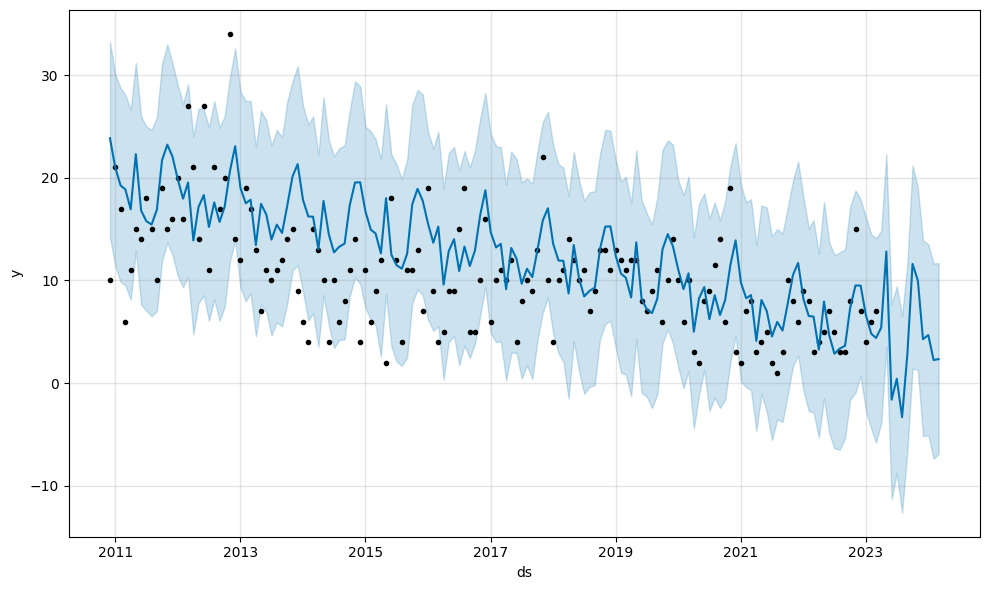

In [103]:
plot3 = m4.plot(specific_ward_forecast)

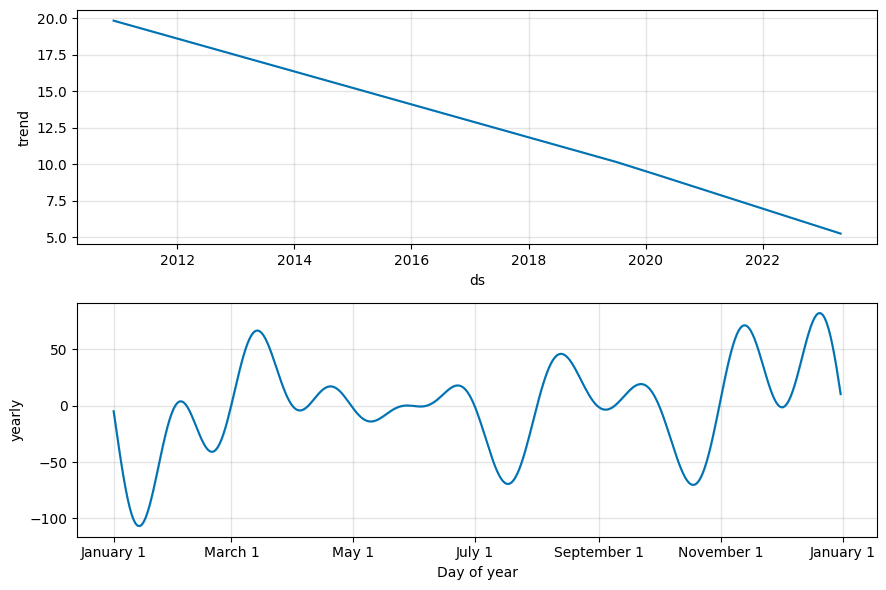

In [53]:
plot3 = m4.plot_components(specific_ward_forecast)

In [105]:
pred = specific_ward_forecast[specific_ward_forecast['ds']<='2023-03-01']
# Calculate MSE
mse = mean_squared_error(df_interpolated['Barnet Vale'], pred['yhat'])
mse

22.772056430701813

In [135]:
# Calculate R2 score
total = 0
for ward in ward_forecasts:
    specific_ward_forecast = ward_forecasts[ward]
    pred = specific_ward_forecast[specific_ward_forecast['ds']<='2023-03-01']
    r2 = r2_score(df_interpolated[ward], pred['yhat'])
    print(r2)
    total += r2

total/len(ward_forecasts)

0.5103259518295635
0.588275868689442
0.2878554504332883
0.35505294107547525
0.14490408563849777
0.27264173880387277
0.5865068613640125
0.30016526531659227
0.35659267086061575
0.42445723157854887
0.29902798383234563
0.6292195541757499
0.4144358763248761
0.37693688566080175
0.26291845141081716
0.4642606077745167
0.5016841118140394
0.3341486196369652
0.4104337534297693
0.5164268090599013
0.433413149449401
0.40152524708830284
0.508608651329167


0.4078181637641983